# Isolation Forest

Z. W. Miller - Copyright 2018

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [10]:
import math
import numpy as np

class isolation_tree:
    
    def __init__(self):
        """
        
        """
        self.tree = self.tree_split(depth=0)
        self.mean_depth = None
    
    # Sub class for handling recursive nodes (only makes sense in the scope of a tree)
    class tree_split:
        """
        A sub class for handling recursive nodes. Each node will contain the value and column
        for the current split, as well as links to the resulting nodes from the split. The 
        results attribute remains empty unless the current node is a leaf. 
        """
        def __init__(self,col=-1,value=None,results=None,label=None,tb=None,fb=None,depth=None):
            self.col=col # column index of criteria being tested
            self.value=value # vlaue necessary to get a true result
            self.results=results # dict of results for a branch, None for everything except endpoints
            self.tb=tb # true decision nodes 
            self.fb=fb # false decision nodes
            self.depth=depth
    
    def split_data(self, X, colnum, value):
        """
        Returns: Two sets of data from the initial data. Set 1 contains those that passed
        the condition of data[colnum] >= value
        ----------
        Input: The dataset, the column to split on, the value on which to split
        """
        splitter = None
        if isinstance(value, int) or isinstance(value,float):
            splitter = lambda x: x[colnum] >= value
        else:
            splitter = lambda x: x[colnum] == value
        split1 = [i for i,row in enumerate(X) if splitter(row)]
        split2 = [i for i,row in enumerate(X) if not splitter(row)]
        set1X = X[split1]
        set2X = X[split2]
        return set1X, set2X

    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def fit(self, X):
        """
        Helper function to wrap the fit method. This makes sure the full nested, 
        recursively built tree gets assigned to the correct variable name and 
        persists after training.
        """
        self.tree = self._fit(X)
        self.predict(X)
    
    def _fit(self, X, depth=0):
        """
        Builds the decision tree via a greedy approach, checking every possible
        branch for the best current decision. Decision strength is measured by
        information gain/entropy reduction. If no information gain is possible,
        sets a leaf node. Recursive calls to this method allow the nesting. If
        max_depth is met, all further nodes become leaves as well.
        ---
        Input: X (feature matrix), y (labels)
        Output: A nested tree built upon the node class."""
        X = self.convert_to_array(X)

        if len(X) == 0: return tree_split()
        self.data_cols = X.shape[1]
        
        
        # Here we go through column by column and try every possible split, measuring the
        # information gain. We keep track of the best split then use that to send the split
        # data sets into the next phase of splitting.
        
        col = np.random.randint(self.data_cols)
        value = np.random.uniform(min(X.T[col]), max(X.T[col]))
        set1, set2 = self.split_data(X, col, value)       
        
        # Now decide whether it's an endpoint or we need to split again.
        
        if len(X) > 1:
            true_branch = self._fit(set1, depth=depth+1)
            false_branch = self._fit(set2, depth=depth+1)
            return self.tree_split(col=col, value=value,
                    tb=true_branch, fb=false_branch, depth=depth)
        else:
            return self.tree_split(results=X, depth=depth)
       
    def print_tree(self, indent="---"):
        """
        Helper function to make sure the correct tree gets printed.
        ---
        In: indent (how to show splits between nodes)
        """
        self.__original_indent = indent
        self._print_tree_(self.tree, indent)
    
    def _print_tree_(self, tree, indent):
        """
        Goes through node by node and reports the column and value used to split
        at that node. All sub-nodes are drawn in sequence below the node.
        """
        if tree.results != None: # if this is a end node
            print(str(tree.results))
        else:
            print('Column ' + str(tree.col)+' : '+str(tree.value)+'? ')
            # Print the branches
            print(indent+' True: ', end=' ')
            next_indent = indent+self.__original_indent
            self._print_tree_(tree.tb,indent=next_indent)
            print(indent+' False: ', end=' ')
            self._print_tree_(tree.fb,indent=next_indent)

    def predict(self, newdata):
        """
        Helper function to make sure the correct tree is used to
        make predictions. Also manages multiple rows of input data
        since the tree must predict one at a time.
        ---
        In: new data point of the same structure as the training X.
        Out: numpy array of the resulting predictions
        """
        results = []
        for x in newdata:
            results.append(self._predict(x,self.tree))
        results = self.convert_to_outliers(np.array(results))
        return results
            
    def _predict(self, newdata, tree):
        """
        Uses the reusive structure of the tree to follow each split for
        a new data point. If the node is an endpoint, the available classes
        are sorted by "most common" and then the top choice is returned.
        """
        newdata = self.pandas_to_numpy(newdata)
        if tree.results != None: # if this is a end node
            return tree.depth

        if isinstance(newdata[tree.col], int) or isinstance(newdata[tree.col],float):
            if newdata[tree.col] >= tree.value:
                return self._predict(newdata, tree.tb)

            else:
                return self._predict(newdata, tree.fb)
        else:
            if newdata[tree.col] == tree.value:
                return self._predict(newdata, tree.tb)
            else:
                return self._predict(newdata, tree.fb) 
            
    def convert_to_outliers(self, results):
        """
        """
        if not self.mean_depth:
            self.mean_depth = np.mean(results)
        
        results[results < self.mean_depth] = -1.
        results[results >= self.mean_depth] = 1.
        return results

In [11]:
X = np.random.normal(0,1,size=(100,2))
outlier = np.array([6.,6.]).reshape(-1,2)

it = isolation_tree()
it.fit(X)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [35]:
it.print_tree()

Column 0 : -1.2004611431649321? 
--- True:  Column 0 : -0.29737074053608736? 
------ True:  Column 0 : 1.5300949919363218? 
--------- True:  Column 0 : 1.6393350694083322? 
------------ True:  Column 1 : 2.4209432150751278? 
--------------- True:  [[ 1.79573093  2.69720566]]
--------------- False:  Column 0 : 1.9771480763679452? 
------------------ True:  [[ 1.9881549   0.25284769]]
------------------ False:  Column 1 : 0.11282353884150598? 
--------------------- True:  [[ 1.89307355  1.40711097]]
--------------------- False:  [[ 1.93332664 -0.63812976]]
------------ False:  Column 0 : 1.60050889807945? 
--------------- True:  [[ 1.60154446 -0.61345862]]
--------------- False:  [[ 1.57537179  0.15060943]]
--------- False:  Column 1 : 1.8688881236994983? 
------------ True:  [[ 0.0336564   3.27358373]]
------------ False:  Column 0 : 1.0492697999925278? 
--------------- True:  Column 0 : 1.2771113406345234? 
------------------ True:  Column 0 : 1.402631053499934? 
--------------------- 

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:136: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [26]:
import pandas as pd
import numpy as np

class isolation_forest:
    
    def __init__(self, n_trees = 10):
        """
        
        """
        self.n_trees = n_trees
        self.trees = []
    
    
    def fit(self, X):
        """
       
        """
        X = self.convert_to_array(X)
       
        for _ in range(self.n_trees):
            new_tree = isolation_tree()
            new_tree.fit(X)
            self.trees.append(new_tree)
    
    def predict(self, X):
        """
        Uses the list of tree models built in the fit, doing a predict with each
        model. The associated filter is applied to X, so the model sees the columns
        it has learned about. The final prediction uses the mode of all the trees 
        predictions.
        ---
        Input: X (array, dataframe, or series)
        Output: Class ID (int)
        """
        X = self.convert_to_array(X)
        
        ensemble_predict = self.decision_function(X)
        ensemble_predict[ensemble_predict < 0] = -1.
        ensemble_predict[ensemble_predict >= 0] = 1.
        return ensemble_predict
    
    def decision_function(self, X):
        """
        """
        self.predicts = []
        for tree in self.trees:
            predictions = tree.predict(X).reshape(-1,1)
            self.predicts.append(predictions)
        
        all_tree_predictions = np.hstack(self.predicts)
        ensemble_predict = np.mean(all_tree_predictions, axis=1)
        return ensemble_predict
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

In [27]:
iso_for = isolation_forest(n_trees=100)
iso_for.fit(X)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [28]:
preds = iso_for.predict(X)
preds

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


array([-1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.])

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(-5, 8)

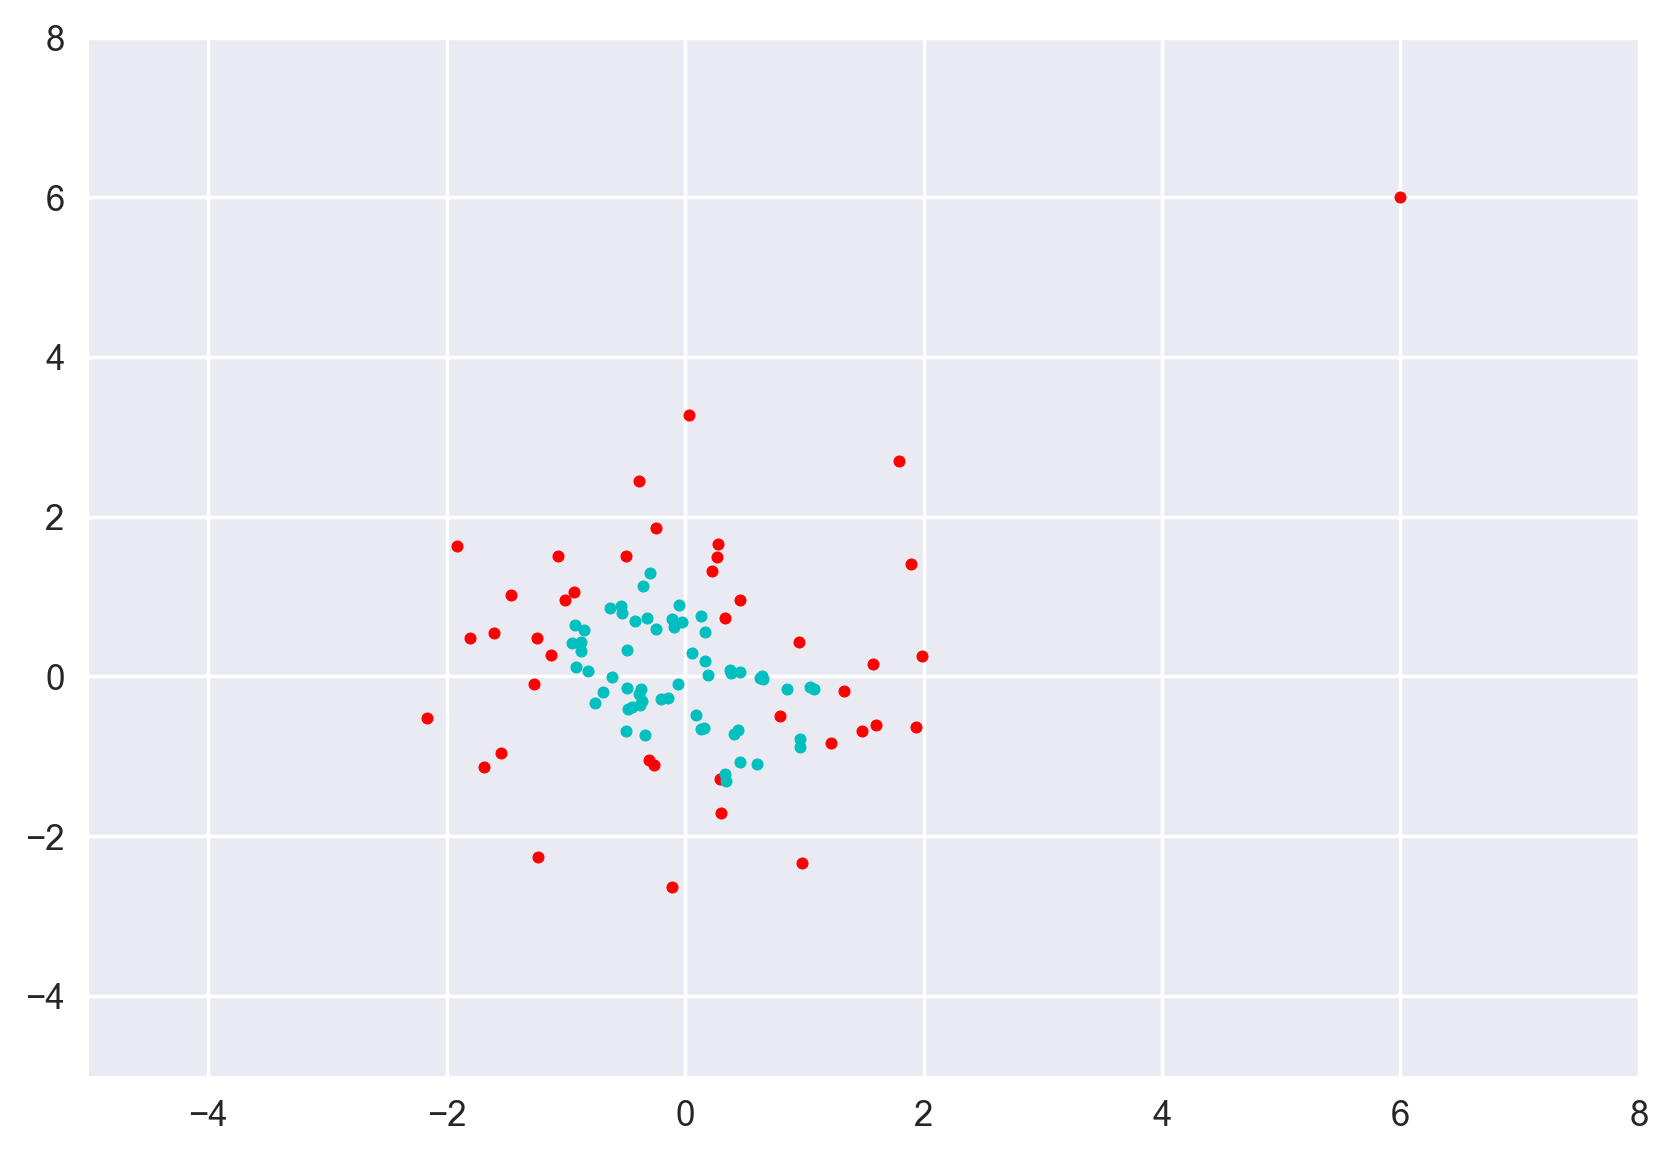

In [29]:
plt.figure(dpi=250)
for pt,label in zip(X,preds):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 
        
for pt,label in zip(outlier,iso_for.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c',s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10)  
        
plt.xlim(-5,8)
plt.ylim(-5,8)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = iso_for.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

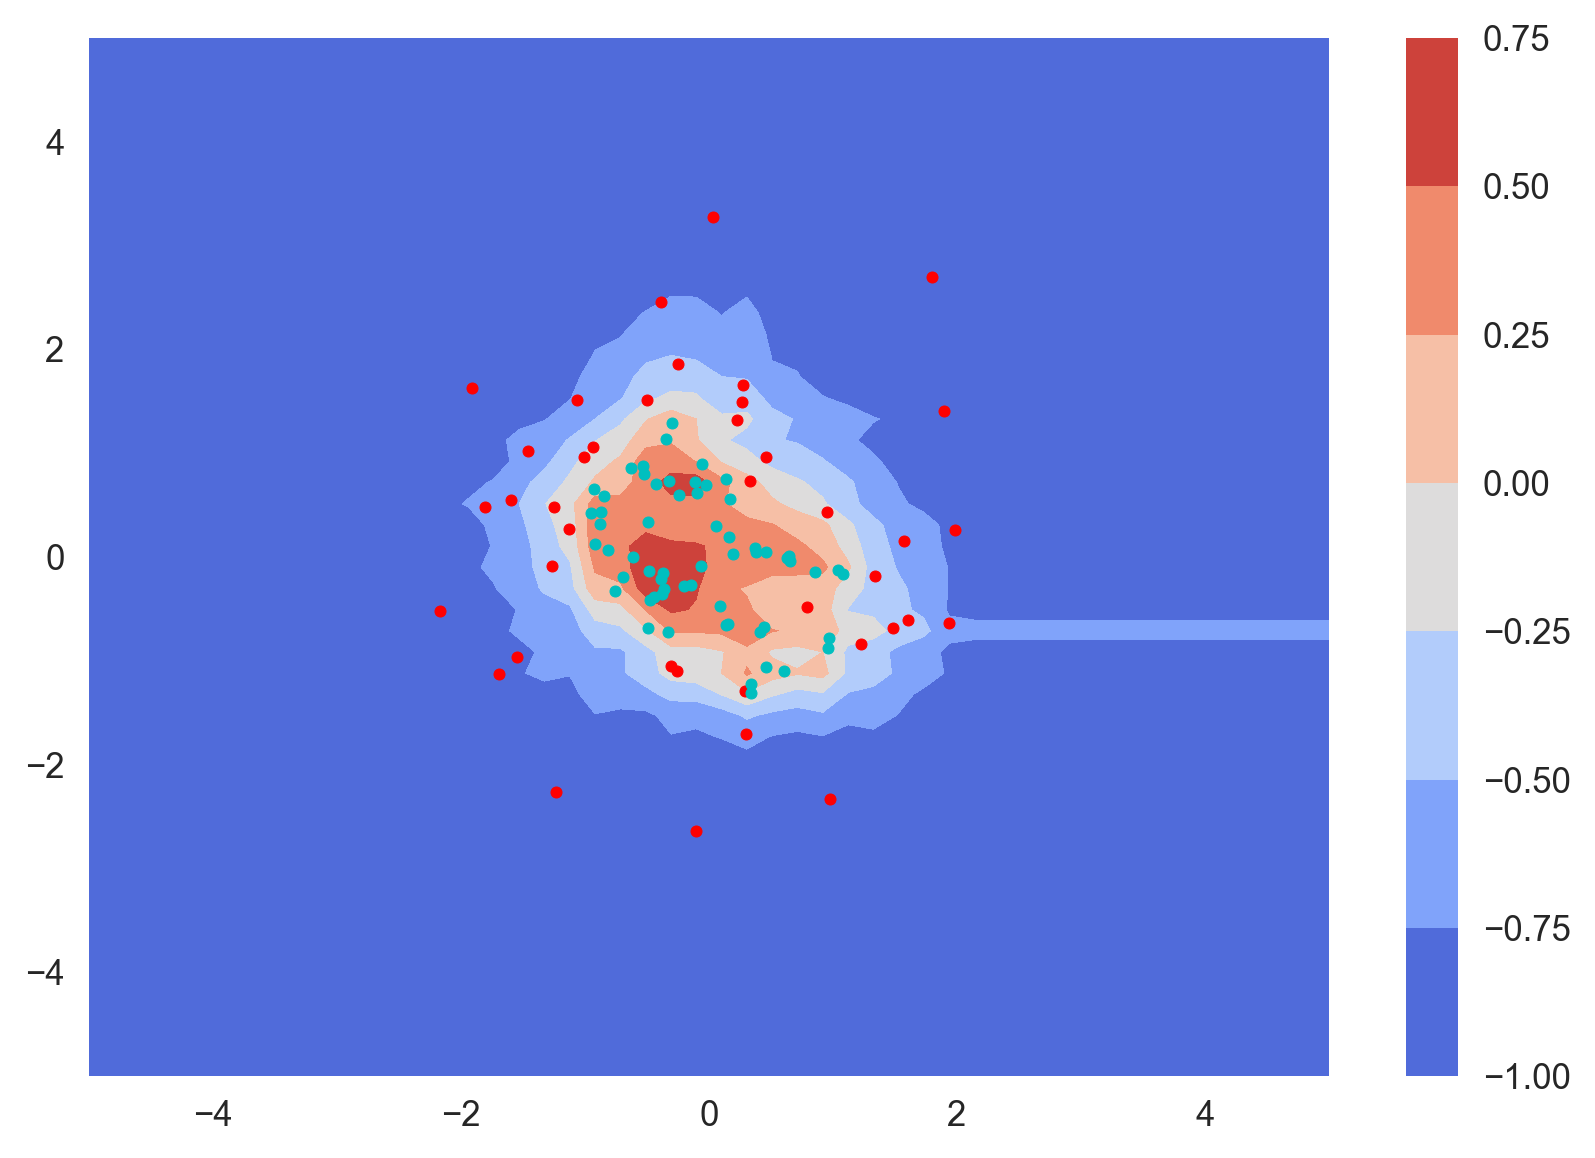

In [40]:
plt.figure(dpi=250)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
plt.colorbar()
for pt,label in zip(X,preds):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c', s=10)
    else:
        plt.scatter(pt[0], pt[1],c='r',s=10) 

In [34]:
iso_for.decision_function(X)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


array([-0.04,  0.3 , -0.16,  0.42, -0.94,  0.24, -0.18,  0.42,  0.22,
       -1.  ,  0.58,  0.42,  0.24,  0.46,  0.56, -0.94, -0.32, -0.08,
        0.12,  0.56,  0.62,  0.2 ,  0.18, -0.42, -0.22, -0.12,  0.44,
        0.18,  0.16,  0.54, -0.26, -0.36,  0.62,  0.5 ,  0.12,  0.82,
        0.3 ,  0.5 , -0.78, -0.82,  0.12, -0.7 ,  0.18, -0.02,  0.6 ,
       -0.64,  0.48, -0.04, -0.26,  0.48,  0.7 ,  0.36,  0.  , -0.5 ,
       -0.96, -0.92, -0.08,  0.86, -0.9 ,  0.84,  0.76,  0.52, -0.7 ,
       -0.14,  0.78,  0.22, -0.94,  0.32,  0.46, -0.26, -0.76, -0.96,
        0.26, -0.7 , -0.34,  0.5 ,  0.46,  0.64, -0.84,  0.54,  0.66,
        0.3 ,  0.6 , -0.6 , -0.62,  0.42,  0.02, -0.16, -0.1 ,  0.6 ,
       -0.36,  0.5 ,  0.48,  0.4 ,  0.2 ,  0.5 ,  0.1 ,  0.34,  0.5 , -0.74])